In [1]:
import gensim
import csv
import pandas as pd
import numpy as np

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# save and load a file
import pickle

/Users/ngohanping/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Importing Training Dataset
Training data are from sentiment140 -- http://help.sentiment140.com/for-students/. <br>
Data set is reduced from 1.6 million to 400k due to it being computationally heavy. <br>

In [2]:
# Read the CSV file into a pandas DataFrame
# Replace 'your_data.csv' with the path to your CSV file
data = pd.read_csv('400k_sampled_data.csv')
data

,sentiment,tweet
0,0,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,"@misstoriblack cool , i have no tweet apps fo..."
2,0,@TiannaChaos i know just family drama. its la...
3,0,School email won't open and I have geography ...
4,0,upper airways problem
...,...,...
399995,0,@brykins Splendid! I was told I looked like a ...
399996,0,@herbadmother I'm so sorry! that IS sad
399997,1,@JosieStingray Sounds like Eddie Murphy is coo...
399998,0,http://twitpic.com/4incl - The tiny Porter pla...


## Defining proprocessing functions
We are looking to explore two levels of preprocessing, the base level of text lowering and stemming, while the other with the addition of removing urls, hashtags, names, punctuations and non-ascii digits.

In [3]:
# Define a preprocessing function
def preprocess_text(text):
    stop_list = nltk.corpus.stopwords.words('english')
    stemmer = nltk.stem.porter.PorterStemmer()
    
    # Tokenize
    sent = nltk.word_tokenize(text)
    
    # Text lowering
    sent = [w.lower() for w in sent]

    # Stop word removal. Optional!
    # sent = [w for w in sent if w not in stop_list]

    # Stemming. Optional!
    sent = [stemmer.stem(w) for w in sent]
    
    
    return sent

In [4]:
def preprocess_and_tokenize(data):
    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
    
    return stem_data

### Applying preprocessing function to the training data

In [5]:
# Apply the preprocessing function to the "tweet" column
data['preprocessed_tweet'] = data['tweet'].apply(preprocess_text)
data['more_preprocessed_tweet'] = data['tweet'].apply(preprocess_and_tokenize)

data

,sentiment,tweet,preprocessed_tweet,more_preprocessed_tweet
0,0,@chrishasboobs AHHH I HOPE YOUR OK!!!,"[@, chrishasboob, ahhh, i, hope, your, ok, !, ...","[ahhh, i, hope, your, ok]"
1,0,"@misstoriblack cool , i have no tweet apps fo...","[@, misstoriblack, cool, ,, i, have, no, tweet...","[cool, i, have, no, tweet, app, for, my, razr]"
2,0,@TiannaChaos i know just family drama. its la...,"[@, tiannachao, i, know, just, famili, drama, ...","[i, know, just, famili, drama, it, lame, hey, ..."
3,0,School email won't open and I have geography ...,"[school, email, wo, n't, open, and, i, have, g...","[school, email, won, t, open, and, i, have, ge..."
4,0,upper airways problem,"[upper, airway, problem]","[upper, airway, problem]"
...,...,...,...,...
399995,0,@brykins Splendid! I was told I looked like a ...,"[@, brykin, splendid, !, i, wa, told, i, look,...","[splendid, i, wa, told, i, look, like, a, moom..."
399996,0,@herbadmother I'm so sorry! that IS sad,"[@, herbadmoth, i, 'm, so, sorri, !, that, is,...","[i, m, so, sorri, that, is, sad]"
399997,1,@JosieStingray Sounds like Eddie Murphy is coo...,"[@, josiestingray, sound, like, eddi, murphi, ...","[sound, like, eddi, murphi, is, cook, tonight,..."
399998,0,http://twitpic.com/4incl - The tiny Porter pla...,"[http, :, //twitpic.com/4incl, -, the, tini, p...","[the, tini, porter, plane, that, took, me, fro..."


## Converting into train/test data
Data are split into labels and corpus, accordingly to what was split. <br>
Afterwards, each sentence will be vectorised and stored in the dictionary, together with its respective label. <br>

In [6]:
# Split the data into training and test data (80% train, 20% test)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [7]:
# We use the following list to store the sequence of sentence labels.
train_labels = []

# We use the following list to store the sentences, where each sentence itself is a list of words.
train_corpus = []

# We use the following list to store the sentences, where each sentence itself is a list of words.
m_train_corpus = []

for index, row in train_data.iterrows():
    train_corpus.append(row['preprocessed_tweet'])
    m_train_corpus.append(row['more_preprocessed_tweet'])
    train_labels.append(row['sentiment'])

In [8]:
# We use the following list to store the sequence of test sentence labels.
test_labels = []

# We use the following list to store the sentences, where each sentence itself is a list of words.
test_corpus = []

# We use the following list to store the sentences, where each sentence itself is a list of words.
m_test_corpus = []

for index, row in test_data.iterrows():
    test_corpus.append(row['preprocessed_tweet'])
    m_test_corpus.append(row['more_preprocessed_tweet'])

    test_labels.append(row['sentiment'])
    
print('Finished reading sentences from the training data file.')

Finished reading sentences from the training data file.


In [9]:
print("Amount of training data:", len(train_corpus))
print("Amount of testing data:", len(test_corpus))

Amount of training data: 320000
Amount of testing data: 80000


In [10]:
# Create a dictionary from the corpus.
dictionary = gensim.corpora.Dictionary(train_corpus)

# Store the labeled training data in the following list.
labeled_training_data = []
    
# Going through the two lists in parallel to create the labeled data set.
for (l, s) in zip(train_labels, train_corpus):

    # Convert the original sentence into a vector.
    vector = dictionary.doc2bow(s)
    
    # Create a dict object to store the document vector (in order to use NLTK's classifier later)
    sent_as_dict = {id:1 for (id, tf) in vector}
    
    # Add the labeled sentence to the labeled data set.
    labeled_training_data.append((sent_as_dict, l))
    
print('Finished preparing the training data.')


Finished preparing the training data.


## Another way of converting text into vector before splitting into train/test data

In [11]:
# Step 3: Convert the text data into bag-of-words vectors
vectorizer = CountVectorizer()

# Assuming data['preprocessed_tweet'] is a list of lists (tokenized sentences)
joined_tweets = [' '.join(tokens) for tokens in data['preprocessed_tweet']]

# join tweets after it is preprocessed
X = vectorizer.fit_transform(joined_tweets)
y = data['sentiment']

# Split the data into train and test sets
v_X_train, v_X_test, v_y_train, v_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preparing the test data
By vectorising the sentences into a dictionary and its respective labels.

In [12]:
# Process the test set and predict labels using the trained classifier.
labeled_test_data = []

for s in test_corpus:
    v_vector = dictionary.doc2bow(s)
    v_sent_as_dict = {id: 1 for (id, tf) in v_vector}
    labeled_test_data.append(v_sent_as_dict)
    
print('Finished preparing the test data.')

Finished preparing the test data.


In [13]:
class_names = ['positive', 'negative']

# Evaluations of Classifiers
We will be using confusion matrix to evaluate the accuracy of a model. <br>
So first, we will define the function of confusion matrix that allows us to visualise it.

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Evaluations of Base Model
Base model only consist of minimal preprocessing like text lowering and stemming
### Results after using Naives Bayes

In [15]:
# Training a classifier.
classifier = nltk.NaiveBayesClassifier.train(labeled_training_data)

print('Finished training Naive Bayes classifier.')

Finished training Naive Bayes classifier.


In [16]:
# Training data accuracy using naive bayes
print("Accuracy on training data using Naive Bayes: ", nltk.classify.accuracy(classifier, labeled_training_data))

Accuracy on training data using Naive Bayes:  0.85834375


In [17]:
# predict labels using the trained classifier.
predicted_labels = [classifier.classify(sent) for sent in labeled_test_data]

Accuracy: 76.46%
Precision: 77.10%
Recall: 76.46%
F1 Score: 0.76


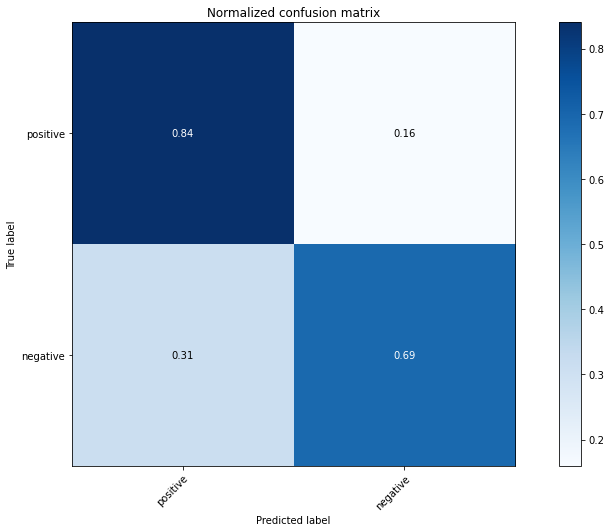

In [18]:
print("Accuracy: {:.2f}%".format(accuracy_score(test_labels, predicted_labels) * 100))
print("Precision: {:.2f}%".format(precision_score(test_labels, predicted_labels, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(test_labels, predicted_labels, average='weighted') * 100))
print("F1 Score: {:.2f}".format(f1_score(test_labels, predicted_labels, average='weighted')))

# Plot normalized confusion matrix
plot_confusion_matrix(test_labels, predicted_labels, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Results after using maxent

In [19]:
#Set iterations and the define classifer
numIterations = 10
algorithm = nltk.classify.MaxentClassifier.ALGORITHMS[0]

#Train the classifier 
entclassifier = nltk.MaxentClassifier.train(labeled_training_data, algorithm, max_iter=numIterations)

print('Finished training Maxent classifier.')

  ==> Training (10 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.501
             2          -0.69314        0.837
             3          -0.69314        0.837
             4          -0.69313        0.837
             5          -0.69313        0.837
             6          -0.69312        0.837
             7          -0.69312        0.837
             8          -0.69311        0.837
             9          -0.69311        0.837
         Final          -0.69310        0.837
Finished training Maxent classifier.


In [20]:
# Training data accuracy using maxent
print("Accuracy on training data using Maxent: ", nltk.classify.accuracy(entclassifier, labeled_training_data))

Accuracy on training data using Maxent:  0.836765625


In [21]:
# predict labels using the trained classifier.
ent_predicted_labels = [entclassifier.classify(sent) for sent in labeled_test_data]

Accuracy: 76.70%
Precision: 77.30%
Recall: 76.70%
F1 Score: 0.77


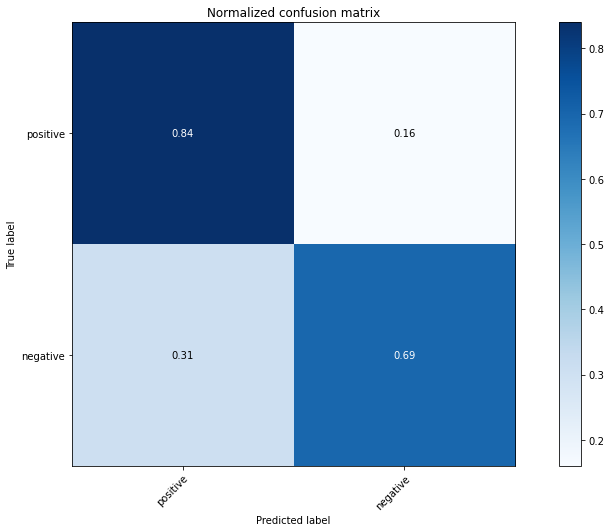

In [22]:
print("Accuracy: {:.2f}%".format(accuracy_score(test_labels, ent_predicted_labels) * 100))
print("Precision: {:.2f}%".format(precision_score(test_labels, ent_predicted_labels, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(test_labels, ent_predicted_labels, average='weighted') * 100))
print("F1 Score: {:.2f}".format(f1_score(test_labels, ent_predicted_labels, average='weighted')))

# Plot normalized confusion matrix
plot_confusion_matrix(test_labels, ent_predicted_labels, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Using Logistic Regression

In [23]:
# Step 4: Train the logistic regression model
lr = LogisticRegression()
lr.fit(v_X_train, v_y_train)

# Step 5: Evaluate the model
y_pred = lr.predict(v_X_test)

/Users/ngohanping/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 78.46%
Precision: 78.48%
Recall: 78.46%
F1 Score: 0.78


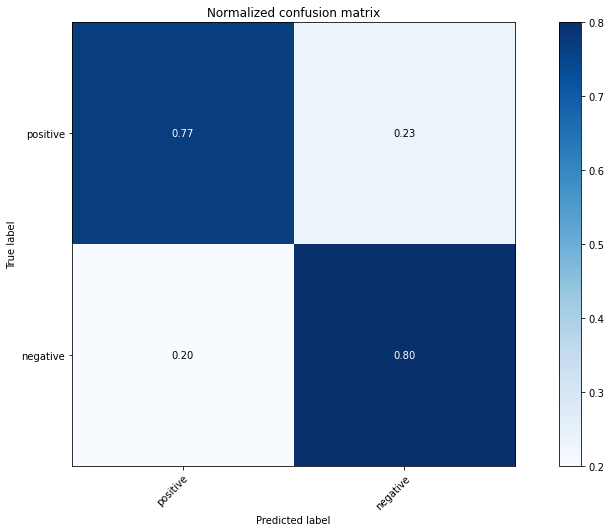

In [24]:
print("Accuracy: {:.2f}%".format(accuracy_score(v_y_test, y_pred) * 100))
print("Precision: {:.2f}%".format(precision_score(v_y_test, y_pred, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(v_y_test, y_pred, average='weighted') * 100))
print("F1 Score: {:.2f}".format(f1_score(v_y_test, y_pred, average='weighted')))

# Plot normalized confusion matrix
plot_confusion_matrix(v_y_test, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Use linear Support Vector Machine (SVM)

In [25]:
# Step 4: Train the linear SVM model
svm = LinearSVC()
svm.fit(v_X_train, v_y_train)

# Step 5: Evaluate the model
y_pred = svm.predict(v_X_test)

/Users/ngohanping/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy: 77.25%
Precision: 77.25%
Recall: 77.25%
F1 Score: 0.77


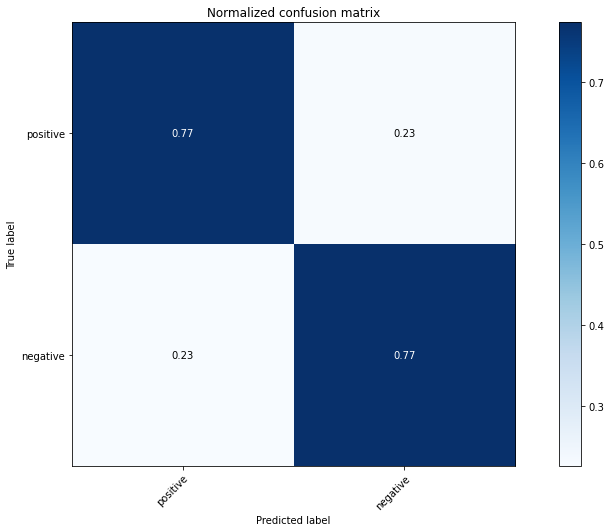

In [26]:
print("Accuracy: {:.2f}%".format(accuracy_score(v_y_test, y_pred) * 100))
print("Precision: {:.2f}%".format(precision_score(v_y_test, y_pred, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(v_y_test, y_pred, average='weighted') * 100))
print("F1 Score: {:.2f}".format(f1_score(v_y_test, y_pred, average='weighted')))

# Plot normalized confusion matrix
plot_confusion_matrix(v_y_test, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Training 2nd model -- with more preprocesses
More preprocessing includes removing urls, hashtags, names, punctuations and non-ascii digits.

## Preparing both training and testing data with more preprocesses

In [27]:
# Create ANOTHER dictionary from more_processed corpus.
m_dictionary = gensim.corpora.Dictionary(m_train_corpus)

# Store the labeled training data in the following list.
m_labeled_training_data = []
    
# Going through the two lists in parallel to create the labeled data set.
for (l, s) in zip(train_labels, m_train_corpus):

    # Convert the original sentence into a vector.
    m_vector = m_dictionary.doc2bow(s)
    
    # Create a dict object to store the document vector (in order to use NLTK's classifier later)
    m_sent_as_dict = {id:1 for (id, tf) in m_vector}
    
    # Add the labeled sentence to the labeled data set.
    m_labeled_training_data.append((m_sent_as_dict, l))
    
print('Finished preparing the ANOTHER training data -- more preprocess.')


Finished preparing the ANOTHER training data -- more preprocess.


In [28]:
# Process the test set and predict labels using the trained classifier.
m_labeled_test_data = []

for s in test_corpus:
    m_v_vector = m_dictionary.doc2bow(s)
    m_v_sent_as_dict = {id: 1 for (id, tf) in m_v_vector}
    m_labeled_test_data.append(m_v_sent_as_dict)
    
print('Finished preparing more processed test data.')

Finished preparing more processed test data.


# Evaluations of 2nd model -- with more preprocessing
More preprocessing includes removing urls, hashtags, names, punctuations and non-ascii digits.
### Results after using Naives Bayes

In [29]:
# Training aNOTHER classifier.
m_classifier = nltk.NaiveBayesClassifier.train(m_labeled_training_data)

print('Finished training another Naive Bayes classifier.')

Finished training another Naive Bayes classifier.


In [30]:
# predict labels using the trained classifier.
predicted_labels = [m_classifier.classify(sent) for sent in m_labeled_test_data]

Accuracy: 74.97%
Precision: 76.72%
Recall: 74.97%
F1 Score: 0.75


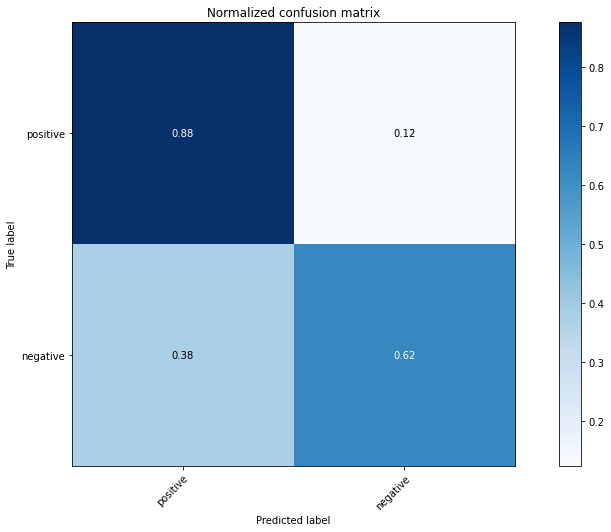

In [31]:
print("Accuracy: {:.2f}%".format(accuracy_score(test_labels, predicted_labels) * 100))
print("Precision: {:.2f}%".format(precision_score(test_labels, predicted_labels, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(test_labels, predicted_labels, average='weighted') * 100))
print("F1 Score: {:.2f}".format(f1_score(test_labels, predicted_labels, average='weighted')))

# Plot normalized confusion matrix
plot_confusion_matrix(test_labels, predicted_labels, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Results after using maxent

In [32]:
#Set iterations and the define classifer
numIterations = 10
algorithm = nltk.classify.MaxentClassifier.ALGORITHMS[0]

#Train the classifier 
m_entclassifier = nltk.MaxentClassifier.train(m_labeled_training_data, algorithm, max_iter=numIterations)

print('Finished training Maxent classifier.')

  ==> Training (10 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.501
             2          -0.69314        0.786
             3          -0.69313        0.786
             4          -0.69311        0.786
             5          -0.69310        0.786
             6          -0.69309        0.786
             7          -0.69308        0.786
             8          -0.69307        0.786
             9          -0.69306        0.786
         Final          -0.69305        0.786
Finished training Maxent classifier.


In [33]:
# predict labels using the trained classifier.
ent_predicted_labels = [m_entclassifier.classify(sent) for sent in m_labeled_test_data]

Accuracy: 75.18%
Precision: 76.89%
Recall: 75.18%
F1 Score: 0.75


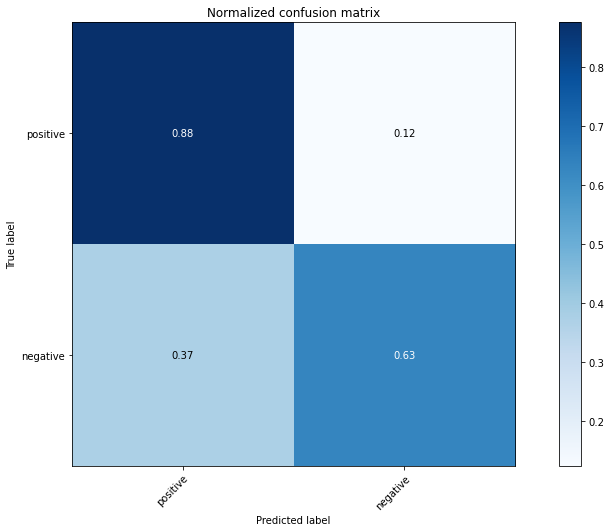

In [34]:
print("Accuracy: {:.2f}%".format(accuracy_score(test_labels, ent_predicted_labels) * 100))
print("Precision: {:.2f}%".format(precision_score(test_labels, ent_predicted_labels, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(test_labels, ent_predicted_labels, average='weighted') * 100))
print("F1 Score: {:.2f}".format(f1_score(test_labels, ent_predicted_labels, average='weighted')))

# Plot normalized confusion matrix
plot_confusion_matrix(test_labels, ent_predicted_labels, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Preliminary Conclusion
With the evaluations done on both model using different classifers, we can conclude that base model with minimal preprocessing has higher accuracy in predicting sentiments regardless of classifiers. These are likely the case:
1. <b>Overfitting</b> -- More extensive preprocessing can result in overfitting, where the model becomes too specialized to the training data and does not generalize well to new data. This is because the model is learning to recognize specific patterns in the training data that may not exist in new data. Minimal preprocessing reduces the risk of overfitting.
2. <b>Noise reduction</b> -- Removing punctuation, Twitter @ names, and URLs can also result in the reduction of noise in the text, which can improve the accuracy of the sentiment analysis. However, in some cases, this may not be beneficial if the noise contains important sentiment-carrying information.
3. <b>Loss of information</b> -- Removing punctuations, Twitter @ names, and URLs can result in the loss of important information that may be relevant to sentiment analysis.

# 3rd Model -- Text Representation
With the current evaluations we had, we seek to explore other ways to improve on the base model that provides adequate accuracy and decided to try a different text representation.<br><br>
Vectorizing text using Term Frequency technique (Term Frequency(TF) — Inverse Dense Frequency(IDF))
* Tokenize with our preprocess_and_tokenize
* Find it’s TF = (Number of repetitions of word in a document) / (# of words in a document)
* IDF = log(# of documents / # of documents containing the word)

The following steps are taken:
1. Prepare train/test dataset
2. Fit sentences to TF-IDF that are either unigrams and bigrams
3. Transform train/test dataset to vectors

In [35]:
X_train = train_data.tweet
X_test = test_data.tweet

y_train = train_data.sentiment
y_test = test_data.sentiment

idf_data = pd.concat([train_data, test_data])

print('size of training set: %s' % (len(train_data['tweet'])))
print('size of validation set: %s' % (len(test_data['tweet'])))
print(idf_data.sentiment.value_counts())

idf_data.head()

size of training set: 320000
size of validation set: 80000
1    200419
0    199581
Name: sentiment, dtype: int64


,sentiment,tweet,preprocessed_tweet,more_preprocessed_tweet
242245,1,The full moon tonight is amazing. Almost like ...,"[the, full, moon, tonight, is, amaz, ., almost...","[the, full, moon, tonight, is, amaz, almost, l..."
288918,0,@buttercupamy I miss Amy cards,"[@, buttercupami, i, miss, ami, card]","[i, miss, ami, card]"
105103,1,At work and reading People's 100 most beautifu...,"[at, work, and, read, peopl, 's, 100, most, be...","[at, work, and, read, peopl, s, most, beauti, ..."
63504,1,@likelyto get how are you doing? thanks for fo...,"[@, likelyto, get, how, are, you, do, ?, thank...","[get, how, are, you, do, thank, for, follow, m..."
239180,1,"Kinky, now I get it","[kinki, ,, now, i, get, it]","[kinki, now, i, get, it]"


In [36]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_text, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

In [37]:
# fit on our complete corpus
vect.fit_transform(idf_data.tweet)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

# Evaluations of 3rd Model

Time to run the different classifiers now that the text has been transformed into vectors. This is so that we can eventually select the most appropriate classifier that we will use for the model.

### Naive Bayes

Accuracy: 79.49%
Precision: 79.92%
Recall: 79.49%

F1 Score: 0.79

Cnfusion Matrix:
 [[34015  5832]
 [10579 29574]]


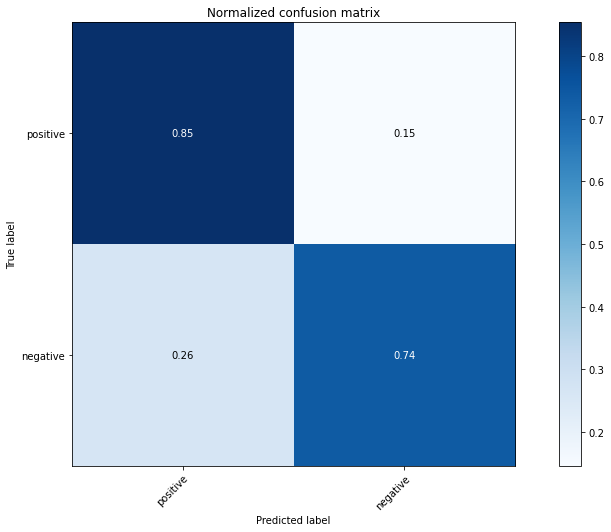

In [38]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, ynb_pred, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, ynb_pred, average='weighted') * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro')))
print("\nCnfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Logistic Regression 

/Users/ngohanping/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 81.23%
Precision: 81.26%
Recall: 81.23%

F1 Score: 0.81

COnfusion Matrix:
 [[31663  8184]
 [ 6833 33320]]


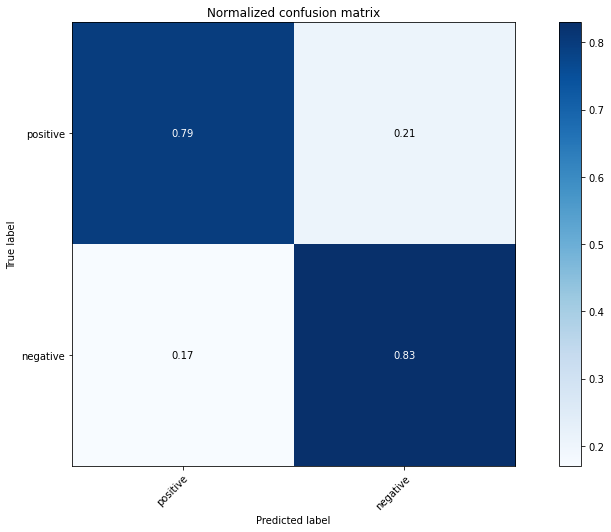

In [39]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, ylog_pred, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, ylog_pred, average='weighted') * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro')))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Linear Support Vector

Accuracy: 81.24%
Precision: 81.27%
Recall: 81.24%

F1 Score: 0.81

COnfusion Matrix:
 [[31720  8127]
 [ 6883 33270]]


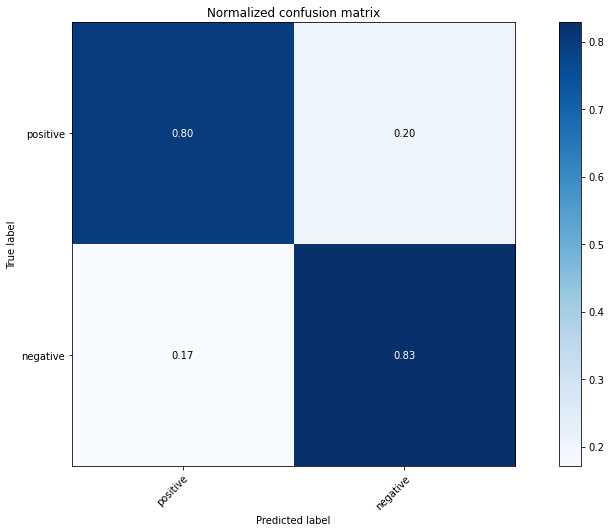

In [40]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, ysvm_pred, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, ysvm_pred, average='weighted') * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro')))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# 4th Model -- with more preprocessing
The team understood that TF-IDF evaluates the importance of a word in a document based on its frequency in the document and its rarity in the entire corpus.<br>
Hence, we would run another test to verify whether more preprocessing produces higher accuracy.

In [41]:
## New vectoriser for more preprocesses
# TFIDF, unigrams and bigrams
m_vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

In [42]:
# fit on our complete corpus
m_vect.fit_transform(idf_data.tweet)

# transform testing and training datasets to vectors
X_train_vect = m_vect.transform(X_train)
X_test_vect = m_vect.transform(X_test)

## Evaluation of 4th Model -- more preprocessing


### Naive Bayes

Accuracy: 79.43%
Precision: 79.69%
Recall: 79.43%

F1 Score: 0.79

Cnfusion Matrix:
 [[33460  6387]
 [10067 30086]]


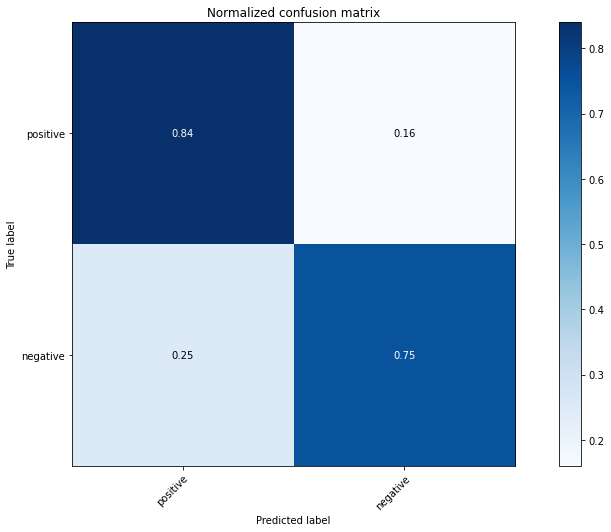

In [43]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, ynb_pred, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, ynb_pred, average='weighted') * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro')))
print("\nCnfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Logistic Regression 

/Users/ngohanping/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 80.97%
Precision: 81.00%
Recall: 80.97%

F1 Score: 0.81

COnfusion Matrix:
 [[31622  8225]
 [ 6997 33156]]


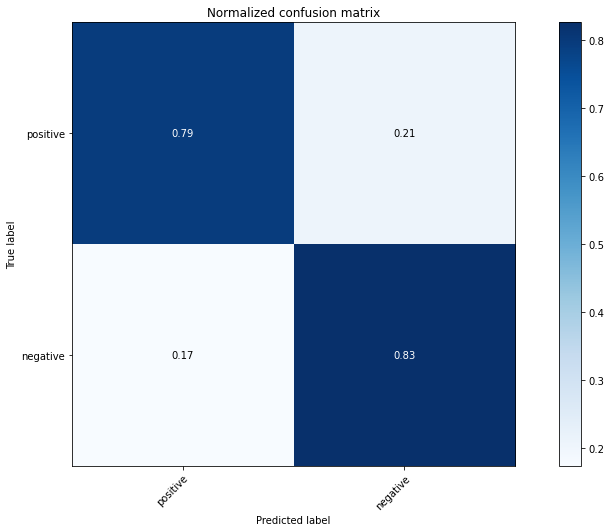

In [44]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, ylog_pred, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, ylog_pred, average='weighted') * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro')))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Linear Support Vector

Accuracy: 80.62%
Precision: 80.64%
Recall: 80.62%

F1 Score: 0.81

COnfusion Matrix:
 [[31512  8335]
 [ 7172 32981]]


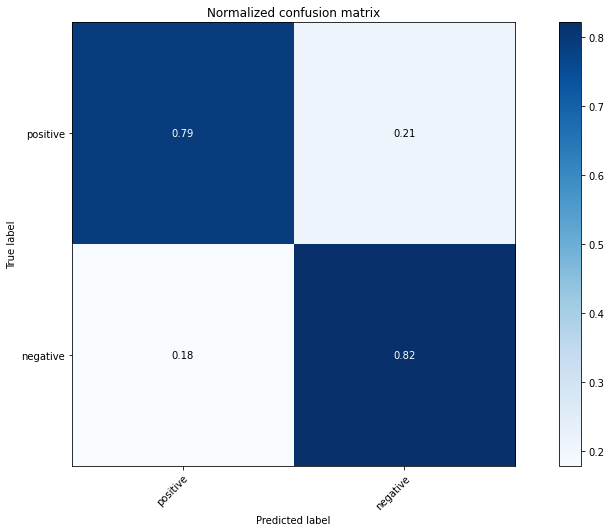

In [45]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, ysvm_pred, average='weighted') * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, ysvm_pred, average='weighted') * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro')))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Conclusion
As we can see, more preprocessing did not produce higher results in both text representation -- document vector & TF-IDF. <br>
Hence, this further supports the idea that having more preprocesses affects the text quality or had a backlash which led to overfitting.<br><br>
Also, it was interesting for us to discover TF-IDF producing better results than document vector as document vector focuses on semantic relationships and context as compared to TF-IDF lacking the ability to capture them. <br>
We further researched and derived some possibilties on why TF-IDF produced better results.
* Nature of tweets are more suited for TD-IDF due to short texts
* Training dataset used are generalised and not domain specific
* Lack of pre-trained word embeddings that provides rich semantic information<br>

Henceforth, possibly allowing TF-IDF to make better predictions of tweet sentiments than document vector.